In [1]:
import os,sys
import pylab
import imp
import numpy as np
from scipy.interpolate import interp1d

In [2]:
EMfile = './THSCPM1_2EqMassAx.py'
ULfile = '../orig/CMS-EXO-13-006_Table_2.dat'

In [3]:
with open(EMfile, 'rb') as fp:
    EM_module = imp.load_module("EM",fp,EMfile, ('.py', 'rb', imp.PY_SOURCE) )
    EMdata = EM_module.validationData

header = 'mstau mreco bg bg_error nobs eff_full exp_ul_full(fb) obs_ul_full(fb) eff_fast exp_ul_fast(fb) obs_ul_fast(fb)'.split()
ULdata = np.loadtxt(ULfile,dtype={'names': header, 'formats' : [float]*len(header)})
ulUL = [[pt['mstau'],pt['obs_ul_fast(fb)']] for pt in ULdata]

In [4]:
ulEM = []
for pt in EMdata:
    ulEM.append([pt['axes']['x'],pt['UL']/pt['efficiency']])
ulEM = np.array(ulEM)

In [5]:
#Interpolate within SModelS:
funcSM = interp1d(ulEM[:,0],ulEM[:,1],bounds_error=False,fill_value=None)
ulEM = [[x[0],funcSM(x[0])] for x in ulUL]

In [6]:
ulEM = np.array(sorted(ulEM))
ulUL = np.array(sorted(ulUL))

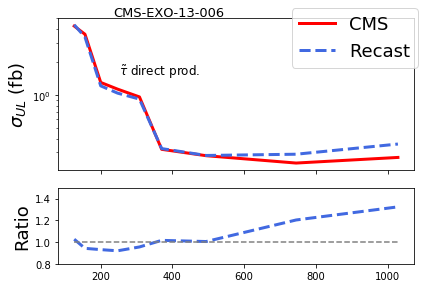

In [7]:
colors = ['red','royalblue']
legends = ['CMS',r'Recast']
linestyles = ['-','--']

#Compute ratios
ratio = []
for i,pt in enumerate(ulEM):
    ptUL = ulUL[i]
    if ptUL[0] != pt[0]:
        print('x-values differ in EM and UL data!')
        break    
    ratio.append([pt[0],pt[1]/ptUL[1]])
ratio = np.array(ratio)

#Define subplots and their properties:
f, axarr = pylab.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[3, 1.5]})
pylab.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Plot curves
curves = []
points = [ulUL,ulEM]
for i,pts in enumerate(points):
    l, = axarr[0].plot(pts[:,0],pts[:,1],linestyles[i],color=colors[i],linewidth=3.0,mec='white')
    curves.append(l)

axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$\sigma_{UL}$ (fb)',fontsize=18)

#Plot ratio
axarr[1].plot(ratio[:,0],ratio[:,1],linestyles[1],color=colors[1],linewidth=3.0)
axarr[1].plot(ulUL[:,0],[1.]*len(ulUL),'--',color='gray')
axarr[1].set_ylabel('Ratio', fontsize=18) #Y-label
ymax = 1.5
ymin = 0.8
max_yticks = 4
yloc = pylab.MaxNLocator(max_yticks)
axarr[1].yaxis.set_major_locator(yloc)
axarr[1].set_ylim([ymin,ymax]) #Y limits
axarr[0].text(250,1.5, r'$\tilde{\tau}$ direct prod.', fontsize=12)
f.legend(curves,legends[:len(curves)], prop={'size': 18})
title = 'CMS-EXO-13-006'
f.suptitle(title, fontsize=13, x=0.4,y=0.99)
f.tight_layout()
f.savefig('ULratio_CMS-EXO-13-006.pdf')